In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import copy
import random
import matplotlib.pyplot as plt
from src.util import *
from src.route_planning import *
from src.delay_model import *
from src.transport_network import *
from sanity_test.graph_test import *
from sanity_test.path_test import *

In [4]:
# build the sbb network
sbb_network = TransportNetwork('data/sbb_timetable_stop_times.parquet', 'data/stop_to_stop.csv', 'data/stops.csv')
stops = sbb_network.stops
stop_to_stop = sbb_network.stop_to_stop
id_to_stop = stops.set_index('stop_id')['stop_name'].to_dict()
stop_to_id = stops.set_index('stop_name')['stop_id'].to_dict()
stop_info = stops.set_index('stop_id')[['stop_lat', 'stop_lon', 'stop_name']].to_dict('index')

## Check on Random Pairs
### Generating Test Paths
We will define a function `generate_paths_for_tests` to generate test paths. This function includes random tests during peak times and boundary tests in the Lausanne area. We will use a seed to ensure reproducibility.

1. **Peak Time Random Tests**
- Randomly sample pairs of stops and generate paths for them during peak travel times (e.g., 10:00 - 12:00).

2. **Boundary Time Tests in Lausanne Area**
- Test paths between stops within the Lausanne area during late night and early morning hours (e.g., 23:00 - 01:00 and 05:30 - 07:30).

Additionally, `graph_sanity_check` is applied every time a new graph is built to perform the following sanity checks on the graph:
1. **No Zero Cycles**: Ensure there are no cycles with zero total weight.
2. **Edge Weight >= 0**: All edges should have non-negative weights (travel time).
3. **Walking Weight > 0**: Ensure that walking weights are positive.

In [3]:
def generate_paths_for_tests(sbb_network, peak_time = ('10:00', '12:00'),
                             boundary_times = [('23:00', '01:00'), ('05:30', '07:30')], seed=42):
    if seed is not None:
        random.seed(seed)


    # Sample some random pairs of stops 
    sample_size = 10
    sampled_pairs = random.sample(list(stop_to_id.keys()), sample_size * 2)  # Get 2 * sample_size to form pairs
    sampled_pairs = [(sampled_pairs[i], sampled_pairs[i + 1]) for i in range(0, len(sampled_pairs), 2)]

    # Only do the boundary test in the Lausanne area
    lausanne_stops = [stop for stop in stop_to_id.keys() if 'Lausanne' in stop]
    lausanne_sample = random.sample(lausanne_stops, sample_size * 2)
    lausanne_pairs = [
        (lausanne_sample[i], lausanne_sample[i + 1]) 
        for i in range(0, len(lausanne_sample), 2)
    ]

    all_generated_paths = []

    # Peak time random test
    G_peak = sbb_network.build_graph(peak_time[0], peak_time[1])
    print(f'-----------Peak time test during {peak_time}-----------')
    graph_sanity_check(G_peak)
    print('...')
    for departure, destination in sampled_pairs:
        departure_id = stop_to_id.get(departure, None)
        destination_id = stop_to_id.get(destination, None)
        print(f"Testing path from {departure} (ID: {departure_id}) to {destination} (ID: {destination_id})")
        if not departure_id or not destination_id:
            print(f" Invalid departure or destination for test: {departure}, {destination}")
            continue
        try:
            paths = yen_ksp(G_peak, peak_time[0], departure_id, destination_id)
            if not paths:
                print(f" No paths found for {departure} to {destination} from {peak_time[0]} to {peak_time[1]}")
                continue
            all_generated_paths.extend(paths)
            print(f" Generated {len(paths)} paths for {departure} to {destination}")
        except KeyError as e:
            print(f" KeyError generating paths for {departure} to {destination}: {e}")
        except Exception as e:
            print(f" Error generating paths for {departure} to {destination}: {e}")

    # City center boundary test (contains 'Lausanne')
    for boundary_time in boundary_times:
        G_boundary = sbb_network.build_graph(boundary_time[0], boundary_time[1])
        print('\n')
        print(f'-----------Boundary time test during {boundary_time}-----------')
        graph_sanity_check(G_boundary)
        print('...')
        for departure, destination in lausanne_pairs:
            departure_id = stop_to_id.get(departure, None)
            destination_id = stop_to_id.get(destination, None)
            print(f"Testing path from {departure} (ID: {departure_id}) to {destination} (ID: {destination_id})")
            if not departure_id or not destination_id:
                print(f" Invalid departure or destination for test: {departure}, {destination}")
                continue
            try:
                paths = yen_ksp(G_boundary, boundary_time[0], departure_id, destination_id)
                if not paths:
                    print(f" No paths found for {departure} to {destination} from {boundary_time[0]} to {boundary_time[1]}")
                    continue
                all_generated_paths.extend(paths)
                print(f" Generated {len(paths)} paths for {departure} to {destination}")
            except KeyError as e:
                print(f" KeyError generating paths for {departure} to {destination}: {e}")
            except Exception as e:
                print(f" Error generating paths for {departure} to {destination}: {e}")

    return all_generated_paths


In [6]:
generated_paths = generate_paths_for_tests(sbb_network)

-----------Peak time test during ('10:00', '12:00')-----------
Graph with 504 nodes passed the sanity check!
...
Testing path from Lausanne, Bellerive (ID: 8591989) to Epalinges, Grand Chemin (ID: 8591968)
 Generated 5 paths for Lausanne, Bellerive to Epalinges, Grand Chemin
Testing path from Bussigny, Tatironne (ID: 8506905) to Lausanne, Praz-Berthoud (ID: 8592099)
 Generated 5 paths for Bussigny, Tatironne to Lausanne, Praz-Berthoud
Testing path from Lausanne, Riant-Cour (ID: 8592110) to Lausanne, Ours (ID: 8579237)
 Generated 5 paths for Lausanne, Riant-Cour to Lausanne, Ours
Testing path from Lausanne, Maladière-Figuiers (ID: 8593837) to Lausanne, Blécherette (ID: 8591994)
 Generated 5 paths for Lausanne, Maladière-Figuiers to Lausanne, Blécherette
Testing path from Lausanne, Petit Château (ID: 8592091) to Ecublens VD, Perrettes (ID: 8591954)
 Generated 5 paths for Lausanne, Petit Château to Ecublens VD, Perrettes
Testing path from Lausanne, EPSIC (ID: 8592041) to Pully, port (ID: 

### Path Sanity Check

We perform the following `path_sanity_check` on the generated paths:

1. **Departure Time >= Arrival Time of the Previous Stop**: Ensure that the departure time from each stop is not earlier than the arrival time at the previous stop.
2. **Transfer Time >= 2 Minutes**: Ensure that the departure time at any transfer stop is at least 2 minutes later than the last arrival time.
3. **Walking Time <= 10 Minutes**: Ensure that walking time between stops does not exceed 10 minutes.

These checks ensure that the generated paths are realistic and adhere to our assumptions.

In [4]:
path_sanity_check(generated_paths)

All paths passed the sanity check.


## Compare with Google Maps:
Some examples

### 1. Lausanne, Bellerive -> Ecublens, EPFL:
- Arrive by 08:10 AM, Monday 27th May

In [9]:
start_time = '07:40'
expected_time = "08:20"
departure = "Lausanne, Bellerive"
destination = "Ecublens VD, EPFL"

In [10]:
G = sbb_network.build_graph(start_time, expected_time)
departure_id = stop_to_id[departure]
destination_id = stop_to_id[destination]

In [17]:
paths = yen_ksp(G, start_time, departure_id, destination_id)
print_paths(paths, id_to_stop, stop_info, limit = 3)

Path 1: Transfers: 0, Cost: 24 minutes, Walking: 7 minutes
Depart from Lausanne, Bellerive(8591989) at 7:45: 
            Lausanne, Théâtre de Vidy(8592121) at 7:46 via 24
            Lausanne, Vidy-Port(8595938) at 7:48 via 24
            Lausanne, Stade de Coubertin(8595935) at 7:49 via 24
            Lausanne, Siège du CIO(8595934) at 7:51 via 24
            Lausanne, Parc Bourget(8595939) at 7:52 via 24
            Lausanne, sports UNIL-EPFL(8595937) at 7:55 via 24
            Chavannes-R., UNIL-Chamberonne(8501211) at 8:02 via walking
            Chavannes-R., UNIL-Mouline(8501212) at 8:05 via m1
            Ecublens VD, UNIL-Sorge(8501213) at 8:06 via m1
            Ecublens VD, EPFL(8501214) at 8:08 via m1
Arrival at Ecublens VD, EPFL(8501214) at 8:08
Path 2: Transfers: 1, Cost: 24 minutes, Walking: 0 minutes
Depart from Lausanne, Bellerive(8591989) at 7:45: 
            Lausanne, Théâtre de Vidy(8592121) at 7:46 via 24
            Lausanne, Vidy-Port(8595938) at 7:48 via 24
   

**The planner shows similar results as google map**
![Google Map Route](img/google_epfl.png)

### 2. Lausanne, Bellerive -> Lausanne, Gare:
- Arrive by 6:00 AM, Monday 27th May

In [18]:
start_time = '05:40'
expected_time = "06:00"
departure = "Lausanne, Bellerive"
destination = "Lausanne, gare"
G = sbb_network.build_graph(start_time, expected_time)
departure_id = stop_to_id[departure]
destination_id = stop_to_id[destination]

In [19]:
paths = yen_ksp(G, start_time, departure_id, destination_id)
print_paths(paths, id_to_stop, stop_info, limit = 3)

Path 1: Transfers: 0, Cost: 11 minutes, Walking: 2 minutes
Depart from Lausanne, Bellerive(8591989) at 5:42: 
            Lausanne, Pêcheurs(8592090) at 5:42 via 2
            Lausanne, Ouchy-Olympique(8592086) at 5:44 via 2
            Lausanne, Beau-Rivage(8591986) at 5:45 via 2
            Lausanne, Jordils(8592061) at 5:46 via 2
            Lausanne, Croix d'Ouchy(8592026) at 5:47 via 2
            Lausanne, Délices(8592028) at 5:49 via walking
                          (8592052) at 5:52 via m2
            Lausanne, gare(8592050) at 5:53 via m2
Arrival at Lausanne, gare(8592050) at 5:53
Path 2: Transfers: 0, Cost: 11 minutes, Walking: 2 minutes
Depart from Lausanne, Bellerive(8591989) at 5:42: 
            Lausanne, Pêcheurs(8592090) at 5:42 via 2
            Lausanne, Ouchy-Olympique(8592086) at 5:44 via 2
            Lausanne, Beau-Rivage(8591986) at 5:45 via 2
            Lausanne, Jordils(8592061) at 5:46 via 2
            Lausanne, Croix d'Ouchy(8592026) at 5:47 via 2
        

**The planner shows similar results as google map**
![Google Map Route](img/google_gare.png)

### 3. Lutry, Colline -> Renens VD, Censuy:
- Arrive by 19:20 PM, Monday 27th May

In [22]:
start_time = '18:40'
expected_time = "19:30"
departure = "Lutry, Colline"
destination = "Renens VD, Censuy"
G = sbb_network.build_graph(start_time, expected_time)
departure_id = stop_to_id[departure]
destination_id = stop_to_id[destination]

In [23]:
paths = yen_ksp(G, start_time, departure_id, destination_id)
print_paths(paths, id_to_stop, stop_info, limit = 3)

Path 1: Transfers: 0, Cost: 27 minutes, Walking: 5 minutes
Depart from Lutry, Colline(8592151) at 18:43: 
            La Conversion, gare(8591976) at 18:44 via 68
            La Conversion(8504010) at 18:46 via walking
            Pully-Nord(8504000) at 18:51 via 6
            Lausanne(8501120) at 18:55 via 6
            Prilly-Malley(8518452) at 19:01 via 6
            Renens VD(8501118) at 19:04 via 6
            Renens VD, gare sud(8588983) at 19:07 via walking
            Renens VD, Censuy(8592209) at 19:10 via 33
Arrival at Renens VD, Censuy(8592209) at 19:10
Path 2: Transfers: 0, Cost: 27 minutes, Walking: 10 minutes
Depart from Lutry, Colline(8592151) at 18:40: 
            La Conversion(8504010) at 18:47 via walking
            Pully-Nord(8504000) at 18:51 via 6
            Lausanne(8501120) at 18:55 via 6
            Prilly-Malley(8518452) at 19:01 via 6
            Renens VD(8501118) at 19:04 via 6
            Renens VD, gare sud(8588983) at 19:07 via walking
            Rene

**The planner shows similar results as google map**
![Google Map Route](img/google_censuy.png)

## Validation for Delay Model
### Generating Confidence Level
We will define a function `generate_cl_for_tests` to generate a set of confidence levels. This function includes results generated by:

1. **Peak Hours in Lausanne**
- Randomly sample pairs of stops in Lausanne and generate CL during peak hours (e.g., 17:00 - 19:00).

2. **Off-Peak Hours in Random Pairs**
- Randomly sample pairs of stops and generate CL during off-peak hours (e.g., 17:00 - 19:00).

In [24]:
# import istdaten data
grouped_istdaten = process_istdaten_data("data/sbb_real_stop_times.parquet")

In [25]:
def generate_cls(sbb_network, peak_time = ('17:00', '19:00') ,
                 off_peak_times = [('5:30', '7:30'), ('13:00', '15:00')], seed=42):
    if seed is not None:
        random.seed(seed)

    sample_size = 10
    sampled_pairs = random.sample(list(stop_to_id.keys()), sample_size * 2)  # Get 2 * sample_size to form pairs
    sampled_pairs = [(sampled_pairs[i], sampled_pairs[i + 1]) for i in range(0, len(sampled_pairs), 2)]

    lausanne_stops = [stop for stop in stop_to_id.keys() if 'Lausanne' in stop]
    lausanne_sample = random.sample(lausanne_stops, sample_size * 2)
    lausanne_pairs = [
        (lausanne_sample[i], lausanne_sample[i + 1]) 
        for i in range(0, len(lausanne_sample), 2)
    ]


    # Peak time random test
    G_peak = sbb_network.build_graph(peak_time[0], peak_time[1])
    # print(f'-----------Peak time test during {peak_time}-----------')
    peak_cl = []
    for departure, destination in lausanne_pairs:
        departure_id = stop_to_id.get(departure, None)
        destination_id = stop_to_id.get(destination, None)
        # print(f"Testing path from {departure} (ID: {departure_id}) to {destination} (ID: {destination_id})")
        if not departure_id or not destination_id:
            print(f" Invalid departure or destination for test: {departure}, {destination}")
            continue
        try:
            paths = yen_ksp(G_peak, peak_time[0], departure_id, destination_id)
            for path, cost in paths:
                confidence = route_confidence(path, peak_time[1], grouped_istdaten)
                peak_cl.append(confidence)
            if not paths:
                continue
        except KeyError as e:
            print(f" KeyError generating paths for {departure} to {destination}: {e}")
        except Exception as e:
            print(f" Error generating paths for {departure} to {destination}: {e}")

    off_peak_dict = {off_peak_time: [] for off_peak_time in off_peak_times}
    for off_peak_time in off_peak_times:
        G_off_peak = sbb_network.build_graph(off_peak_time[0], off_peak_time[1])
        # print(f'-----------Off-peak time test during {off_peak_times}-----------')
        for departure, destination in sampled_pairs:
            departure_id = stop_to_id.get(departure, None)
            destination_id = stop_to_id.get(destination, None)
            # print(f"Testing path from {departure} (ID: {departure_id}) to {destination} (ID: {destination_id})")
            if not departure_id or not destination_id:
                print(f" Invalid departure or destination for test: {departure}, {destination}")
                continue
            try:
                paths = yen_ksp(G_off_peak, off_peak_time[0], departure_id, destination_id)
                for path, cost in paths:
                    confidence = route_confidence(path, off_peak_time[1], grouped_istdaten)
                    off_peak_dict[off_peak_time].append(confidence)
                if not paths:
                    continue
            except KeyError as e:
                print(f" KeyError generating paths for {departure} to {destination}: {e}")
            except Exception as e:
                print(f" Error generating paths for {departure} to {destination}: {e}")

    return peak_cl, off_peak_dict


In [26]:
peak_cl, off_peak_dict = generate_cls(sbb_network)

In [27]:
offpeak_lc_1 = off_peak_dict[list(off_peak_dict.keys())[0]]
offpeak_lc_2 = off_peak_dict[list(off_peak_dict.keys())[1]]

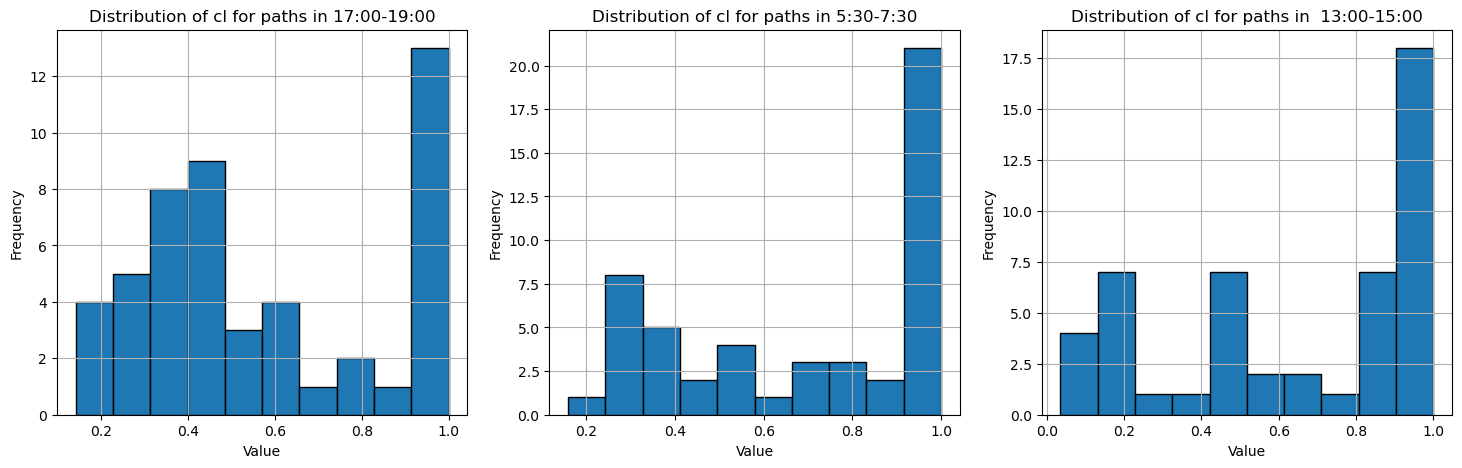

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(peak_cl, bins=10, edgecolor='black')
axes[0].set_title('Distribution of cl for paths in 17:00-19:00')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

axes[1].hist(offpeak_lc_1, bins=10, edgecolor='black')
axes[1].set_title('Distribution of cl for paths in 5:30-7:30')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

axes[2].hist(offpeak_lc_2, bins=10, edgecolor='black')
axes[2].set_title('Distribution of cl for paths in  13:00-15:00')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.show()

This shows that paths in the Lausanne area during peak hours are generally more likely to have a low confidence level, which is aligned to real-life situations.